# Finding Communities of Scholars On Twitter

### created by Elliot Frank, MITH Intern 3.31.17

Hello! This is the first tutorial that uses the Twarc tool from the Documenting the Now project in order to faciliate research on Twitter. The point of this tutorial is an introduction to analyzing communities on Twitter using network analysis. Our task is to create an automatic way to, given a single Twitter user, find the most important people in their social network.

In [14]:
# First thing to do is to simply insert our credentials and start up a Twarc object. 
# You might remember this from last tutorial.

from twarc import Twarc
import pandas as pd
import numpy as np


t = Twarc()



We're going to use Ed Summers' Twitter account as an example! Ed is lead developer at MITH and the creator of the Twarc app. Most importantly, we can quiz him about his followers to see if our suspicions were right.

This tutorial is going to be divided into two parts. The first is getting Ed's community of friends. This task will let us practice two skills: using Twarc to get information from Twitter, and using Networkx to create a network of Ed's followers.

# Collecting Communities

Like we said, the input to our script is going to be a single username, in this case Ed's username (@edsu). The first thing we'll do is get all of Ed's information. If you manually change the "seed_screenname" parameter, this whole tutorial should still get the network for that person.

In [15]:
seed_screenname = 'edsu'   #Here we key in Ed's screenname. This is the only input.

for user in t.user_lookup(screen_names=[seed_screenname]):     # These two lines actually collect all the information 
    seed_user = user                                           # from Ed's account
    
# Let's print Ed's screennme, id, and description
print(seed_user['name'],'follows',seed_user['friends_count'],'accounts and has',seed_user['followers_count'],'followers')

Ed Summers follows 2730 accounts and has 4717 followers


Ed is the center of our social network. Right now, his information is stored in the variable "seed_user", but we'd prefer to put it in a format that is more applicable to working with a social network. So now, we're going to import Networkx, which is a package to create networks. A network, (or graph) consists of nodes and edges; for us, the nodes are going to be the Twitter users, and the edges will be the connections between them. So very simply, we're going to start by adding our first node, Ed.

In [17]:
import networkx as nx

G = nx.Graph()
G.add_node(seed_user['name'])

Now we want to extend our network, so let's start finding his friends. Our network will be composed of every person that Ed follows who follows him back. We're going to call these people "mutual follower". To get this group of people, we're going to separately find the id's of all his followers, and the people he follows, and then find all the id's that appear in both lists.

In [18]:
friends_list = []
followers_list = []

for friend in t.friend_ids(seed_user['screen_name']):
    friends_list.append(str(friend))

for follower in  t.follower_ids(seed_user['screen_name']):
    followers_list.append(str(follower))

print('Just to check our work, we found',len(friends_list),'people that',seed_user['name'],
      'follows and',len(followers_list),'followers.','\n','This should match the numbers we found before')

Just to check our work, we found 2731 people that Ed Summers follows and 4716 followers. 
 This should match the numbers we found before


Now we want to find the mutual relationships Ed has: people who he follows and who follow him. This should pare down those numbers some and help us filter out unimportant relationships.

In [19]:
# We write a simple function to find the intersection of two lists.
def intersection(x,y):
    return list(set(x) & set(y))


mutuals = intersection(friends_list,followers_list)
print('There are',len(mutuals),'mutual followers of Ed')


There are 1125 mutual followers of Ed


Great! We've pared down our number some, but there's still over 1000 accounts. That's still too many to examine by hand, so this is where the network will really come in handy. We want to add each of those mutual followers as nodes to the network. But first, let's look at the first few entries of that variable "mutuals" to see what our data looks like.

In [20]:
mutuals[0:5]

['14513488', '243775854', '56812711', '917105330', '7483862']

As we can see, it's a list of id's. These are good for looking up friends but we might find it easier if we had actual names. We can look that up the same way we looked up Ed's information. Also, here we're going to filter out protected users, because when we look up their followers later it will give us an error.

In [21]:
network_dictionary = {}
for user in t.user_lookup(user_ids = mutuals):
    if user['protected'] == False:
        network_dictionary[user['id_str']] = user['name']

Now we have a dictionary that is a list of user ids along with their names. Let's add all those folks to the network as nodes. And while we're at it, we're going to add edges between Ed and each of those users, because by definition each of those users is someone who is a mutual follower of Ed.

In [24]:
for user in network_dictionary.values():
    G.add_node(user)
    G.add_edge(seed_user['name'],user)
    
# Let's print the first 5 entries to     
print(G.nodes()[0:5])

['William Denton', "Flattery O'Connor", 'Andrew L. Russell', 'Matthew Connelly', 'Richard Marciano']


We're going to visualize a small part of this network that contains Ed's node as well as 25 other nodes, just so we can see a bit of its structure. Try to guess what it's going to look like before we draw it!

The code below is commented somewhat to give an idea of what we're doing, but visualizating networks could be its own tutorial! (or two, or three, or...) So if you don't understand the code here, don't sweat it. 

/Users/elliotgoldingfrank/anaconda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/elliotgoldingfrank/anaconda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/elliotgoldingfrank/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/elliotgoldingfrank/anaconda/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, wil

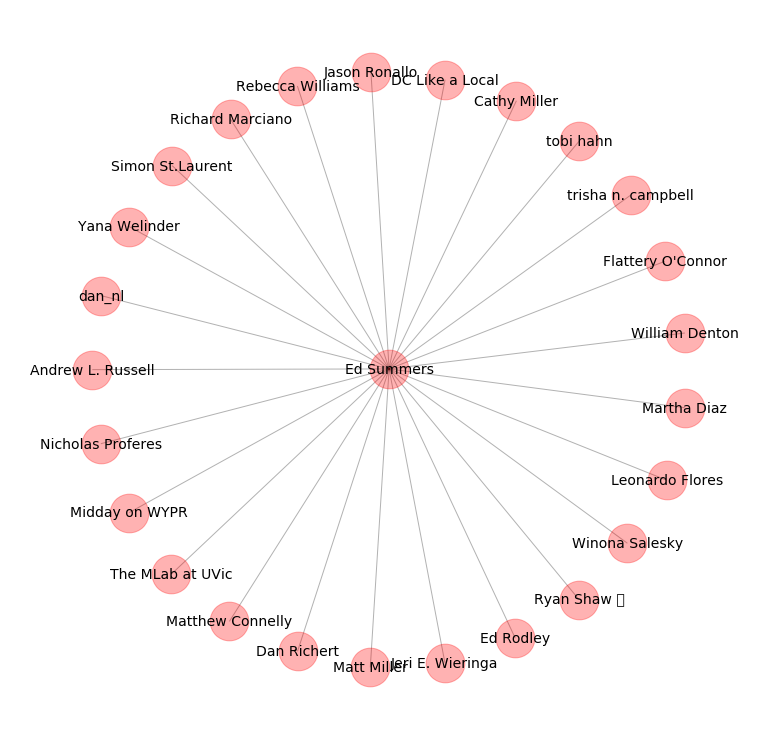

In [25]:
import matplotlib.pyplot as plt
plt.close('all')

# Get subgraph 
sub_G = G.nodes()[0:25]                       # Take 25 nodes from the graph
if seed_user['name'] not in sub_G:    # Make sure Ed's account is in the subgraph
    sub_G.append(seed_user['name'])    
    
sub_G = G.subgraph(sub_G)                     # This actually creates the subgraph, ie takes the nodes we give it
                                               # and fills in the edges


pos = nx.spring_layout(sub_G,scale=.9,k=.3)
options = {'node_size':1500, 'node_color':'r', 'with_labels':True, 'alpha':0.3, 'font_size':14}

plt.figure(1,figsize=(10,10))


ax = plt.axes([0,0,2,1])
ax.set_axis_off()
ax.set_aspect('equal')
nx.draw(sub_G,pos,ax=ax,**options)


plt.show()


Did you guess it would look like a wheel? Remember, this is only a small part of the network, but the entire thing has the same structure. At this point, we want to fill out the network by finding the mutual followers of every one of those mutual followers. In other words, now we're going to look at all those nodes that are connected to Ed, and find the connections between each one of them amongst each other.

### A word of warning: this step will take several hours! 
Unfortunately, Twitter only allows us to make 1 request for a follower list each minute, which means this step is going to take a good part of a day. However, if you're using Ed's account as an example, you can find the output file 'edsu.adjlist' is already in the Github. This file is called an adjacency list, but basically it's a compact way to store the information about the nodes and edges. So, you can skip this next cell and move on to our last cell, visualizing the network! If you're trying to find the network of someone other than Ed, we recommend you leave your computer on for about a day.

In [51]:
for user_A_id, user_A_name in network_dictionary.items():
    if len(G[user_A_name]) > 1:
        pass
    else:
        # First we need to look up all the people the user follows
        user_A_friends = list(t.friend_ids(user_A_id))
        print(user_A_name,len(user_A_friends))
        mutual_fof = intersection(user_A_friends,list(network_dictionary.keys()))   # Now we have a list of mutual ids
        print(user_A_name,'has',len(mutual_fof),'connections')

        # Then we're going to add edges between each of those users in the network.
        for user_B_id in mutual_fof:
            user_B_name = network_dictionary[user_B_id]      # We have their id and want to look up their name.
            G.add_edge(user_A_name,user_B_name)

nx.write_adjlist(G,'edsu.adjlist')


Patrick Summers 4
Patrick Summers has 0 connections
Kesa Summers 26
Kesa Summers has 0 connections
Zoe Nissen 244
Zoe Nissen has 7 connections
Greg Walters 58
Greg Walters has 0 connections


In [54]:
nx.write_adjlist(G,'edsu.adjlist')


Finally, we're going to visualize the subgraph from before. It should look similar, but hopefully now we'll see some lines between followers have been drawn. 

/Users/elliotgoldingfrank/anaconda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/elliotgoldingfrank/anaconda/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/elliotgoldingfrank/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/elliotgoldingfrank/anaconda/lib/python3.5/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, wil

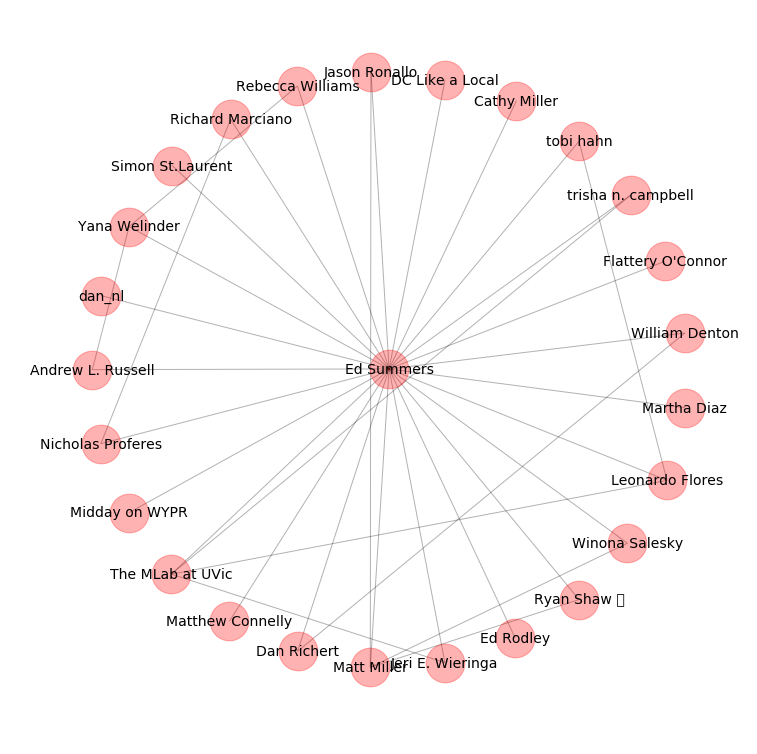

In [53]:
import matplotlib.pyplot as plt
plt.close('all')

# Get subgraph 
sub_G = G.nodes()[0:25]                       # Take 25 nodes from the graph
if seed_user['name'] not in sub_G:    # Make sure Ed's account is in the subgraph
    sub_G.append(seed_user['name'])    
    
sub_G = G.subgraph(sub_G)   # This function takes the list of nodes we give it and fills in the edges

options = {'node_size':1500, 'node_color':'r', 'with_labels':True, 'alpha':0.3, 'font_size':14}

plt.figure(1,figsize=(10,10))

ax = plt.axes([0,0,2,1])
ax.set_axis_off()
ax.set_aspect('equal')
nx.draw(sub_G,pos,ax=ax,**options)

plt.show()